In [1]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow==1.15

Note: you may need to restart the kernel to use updated packages.


In [3]:
#import library# 
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler

## 1. Eksplorasi Data 

In [25]:
#eksplorasi data
df = pd.read_csv(os.path.join('hp.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close']) 
#df=pd.read_csv('AAL.csv')
df = df.sort_values('Date')
#melihat panjang data
print(len(df))
#menampilkan dalam dataframe
df.head()

3645


,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-09-27,21.049999,21.400000,19.100000,19.299999,18.194910,961200
1,2005-09-28,19.299999,20.530001,19.200001,20.500000,19.326199,5747900
2,2005-09-29,20.400000,20.580000,20.100000,20.209999,19.052801,1078200
3,2005-09-30,20.260000,21.049999,20.180000,21.010000,19.806999,3123300
4,2005-10-03,20.900000,21.750000,20.900000,21.500000,20.268938,1057900


## 2. Visualisasi Data 

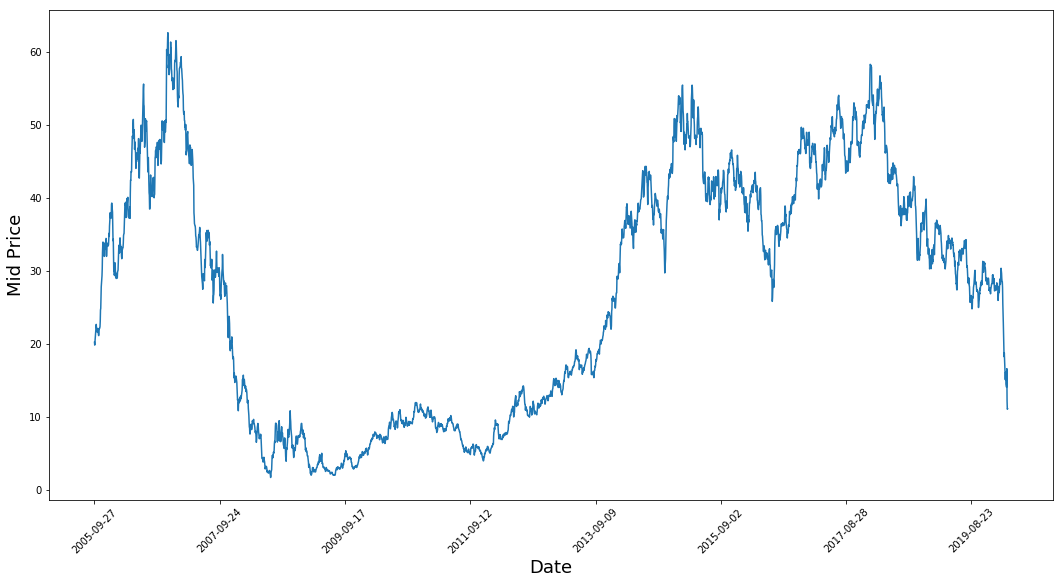

In [6]:
# Visualisasi data
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

## 3. Membagi data menjadi Training dan Testing 

In [7]:
#membagi data menjadi data training dan data testing
#Data saham yang digunakan adalah harga tertinggi dan harga terebdah
high_prices = df.loc[:,'High'].as_matrix()
low_prices = df.loc[:,'Low'].as_matrix()
mid_prices = (high_prices+low_prices)/2.0

C:\Users\Nurdi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Nurdi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [8]:
#membagi data menjadi 11000 data training dan 11000 data testing.
train_data = mid_prices[:11000] 
#11000 untuk data testing
test_data = mid_prices[11000:]
print(train_data)
print(test_data)

[20.25      19.865001  20.34      ... 16.1699995 15.9299995 16.275    ]
[16.2249995 16.2450005 16.045     ... 12.225     11.085     11.15     ]


## 5.Normalisasi Data
### menghilangkan dan mengurangi redudansi data dan  memastikan dependensi data.

In [9]:
# MinMaxScalar skala data berada pada 0 dan 1 kemudian membentuk kembali data pelatihan dan pengujian.
#MinMaxscaler digunakan untuk normalisasi data
scaler = MinMaxScaler()
#Data training dengan range -1 sampai 1 begitu juga Data testing
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [10]:
# Normalisasi data
# Train Scaler dengan data latih dan smooth data
smoothing_window_size = 2500
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# menormalisasi kembali
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [11]:
#membentuk kembali data trining dan testing
train_data = train_data.reshape(-1)

test_data = scaler.transform(test_data).reshape(-1)

In [12]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(11000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

## 6. Data Generator 

In [17]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.00107722 0.59976864 0.382454   0.31013724 0.19187157]

	Output: [0.00407992 0.59664077 0.40214512 0.31010938 0.18524726]


Unrolled index 1
	Inputs:  [0.0009695  0.5979517  0.40214512 0.30706728 0.1879041 ]

	Output: [0.00775698 0.59207934 0.40529457 0.31252077 0.1879041 ]


Unrolled index 2
	Inputs:  [0.00220159 0.59664077 0.41703266 0.3096119  0.18524726]

	Output: [0.00220159 0.5937992  0.38857463 0.31252077 0.18695892]


Unrolled index 3
	Inputs:  [0.00407992 0.5937992  0.41977382 0.31010938 0.18366453]

	Output: [0.0238097  0.5760853  0.41977382 0.31147105 0.18366453]


Unrolled index 4
	Inputs:  [0.00775698 0.59207934 0.41832933 0.31147105 0.18206434]

	Output: [0.01287104 0.5835035  0.37119672 0.31343037 0.19086409]


## 7. mendefinisikan hyperparameter 

In [18]:
D = 1 # Dimensi Data
num_unrollings = 50 #feture
batch_size = 500 # jumlah sample 
num_nodes = [200,200,150] # jumlah hidden (node) yang digunakan untuk LSTM. hidden pertama 200 node, hidden 2 200 node dan hidden 3 150 node
n_layers = len(num_nodes) # layar yang digunakan adalah 3
dropout = 0.2

tf.reset_default_graph() 

## 8. Definisi input dan Output 

In [19]:
# input data
train_inputs, train_outputs = [],[]

for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))


## 8.  Definisi parameter LSTM 

In [20]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

## 9. Menghitung  LSTM   

In [21]:
# Mebuat neuron pada hidden state dalam LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## 10. Loss Calculation and Optimizer 

In [22]:
print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimasisasi
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
	All done


## 11. Perhitungan Prediksi 

In [23]:
sample_inputs = tf.placeholder(tf.float32, shape=[1,D])
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

	All done


## 12.  LSTM 

In [24]:
epochs = 10 # epoch (pelatihan) yang digunakan adalah 10
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 

train_seq_length = train_data.size # panjang data training

train_mse_ot = [] # Akumulasi loss training
test_mse_ot = [] # Akumulasi loss testing
predictions_over_time = [] # Akumulasi prediksi

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 

print('inisialisasi')
average_loss = 0

# mendefinisikan datagenerator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# memulai training
test_points_seq = np.arange(11000,12000,50).tolist()

for ep in range(epochs):       

    # training
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    # validasi
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # loss rata-rata
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 

      predictions_seq = []

      mse_test_loss_seq = []

      # update state dan melakukan prediksi
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          
          x_axis=[]

        for tr_i in range(w_i-num_unrollings+1,w_i-1):
            current_price = all_mid_data[tr_i]
            feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
            _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # membuat prediksi
        # prediksi sebelumnya untuk dijadikan input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
           
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

inisialisasi
Average loss at step 1: 3.597527


IndexError: index 10951 is out of bounds for axis 0 with size 3645

## 13. Visualisasi Prediksi 

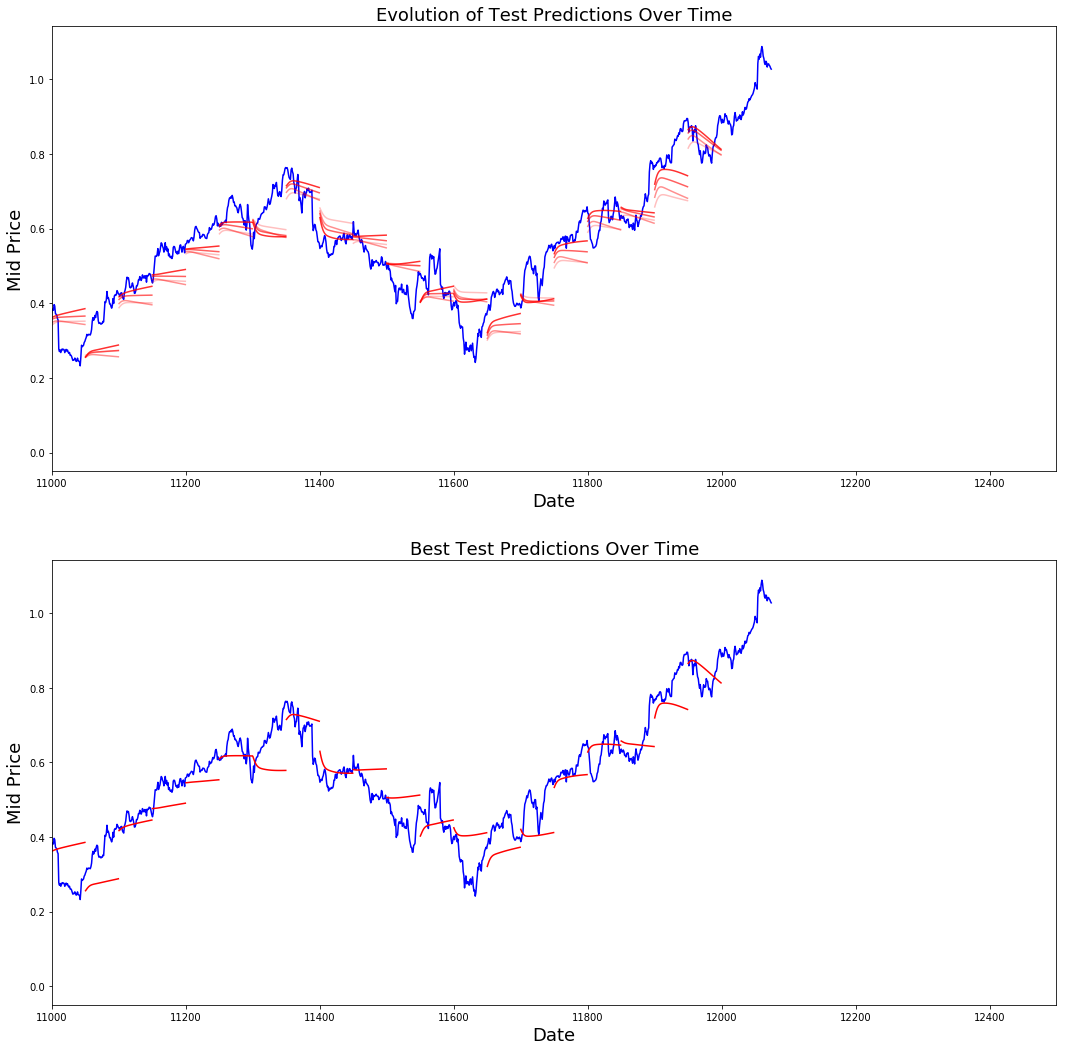

In [84]:
best_prediction_epoch = 9 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plot prediksi 
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)

plt.subplot(2,1,2)

plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)
plt.show()

#### pada model diatas dilakukan epoch (training) sebanyak 10 kali, hasil yang didapat adalah pada epoch 10 MSE bernilai 0.00239 dan dan average loss sebesar 0.055231 yang artinya model tersebut sudah bagus. pada grafik didapatkan prediksi (garis merah) mendekati/menyerupai true data (garis biru) artinya model prediksi sudah mendekati data sebenarnya.  namun perlu dilakukan lebih banyak jumlah epoch (training) yang nantinya diharapkan model dapat memprediksi saham HP dengan MSE terkecil.
